<a href="https://colab.research.google.com/github/amaniitk/Image-Processing-using-Vision-API/blob/main/CV%20with%20Azure%20Vision%20API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install azure-cognitiveservices-vision-computervision


In [ ]:
!pip install pytesseract


Please upload the images you want to process:


Saving test2.png to test2 (7).png
Saving test.jpg to test (11).jpg
Processing image: test2 (7).png
Extracted Text:
Consider the Atwood's machine shown below. The masses
are 4m, 5m, and 3m. Let x and y be the heights of the right
two masses relative to their initial positions. Solve this
problem using Lagrangian Mechanics.
4m
x
y
5m
3m



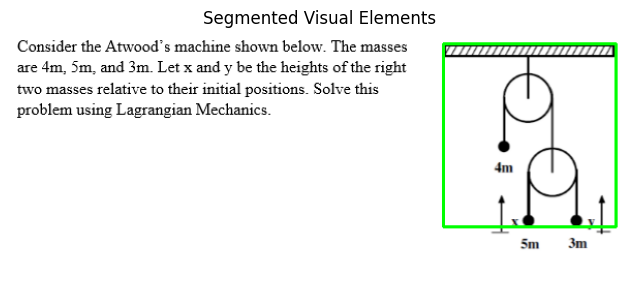

Visual Elements:


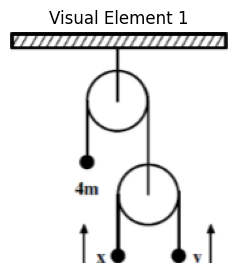

Processing image: test (11).jpg
Extracted Text:
Q. 1: In the given figure, PS/SQ = PT/TR and z PST = _ PRQ. Prove that PQR is an
isosceles triangle.
P
5
T
Q
R



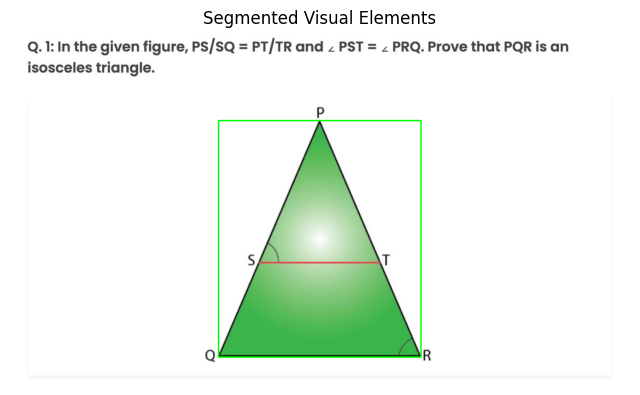

Visual Elements:


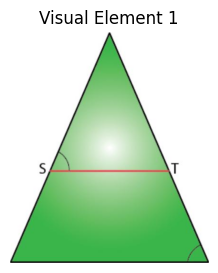

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials

# upload the images
def upload_images():
    print("Please upload the images you want to process:")
    uploaded = files.upload()
    if not uploaded:
        print("No files uploaded")
        return []
    image_paths = list(uploaded.keys())
    return image_paths

# azure CV required details
subscription_key = "8f533c0cd1fd4d90ba297bb1c65778b6"
endpoint = "https://amank.cognitiveservices.azure.com/"
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

def process_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    temp_image_path = "temp_image.jpg"
    cv2.imwrite(temp_image_path, gray)

    with open(temp_image_path, "rb") as image_stream:
        ocr_result = computervision_client.read_in_stream(image_stream, raw=True)

    operation_location = ocr_result.headers["Operation-Location"]
    operation_id = operation_location.split("/")[-1]

    import time
    time.sleep(5)
    # OCR results
    result = computervision_client.get_read_result(operation_id)
    if result.status == "succeeded":
        text = ""
        for line in result.analyze_result.read_results[0].lines:
            text += line.text + "\n"
    else:
        text = "OCR operation failed"

    print("Extracted Text:")
    print(text)

    # Visual Element Segmentation
    def segment_visual_elements(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Extract visual elements
        visual_elements = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Filtering texts
            aspect_ratio = w / float(h)
            area = w * h
            if 0.2 < aspect_ratio < 5 and area > 1000:
                visual_elements.append((x, y, x+w, y+h))

        # Highlighting visual elements
        img_with_elements = image.copy()
        for vertices in visual_elements:
            cv2.rectangle(img_with_elements, (vertices[0], vertices[1]), (vertices[2], vertices[3]), (0, 255, 0), 2)

        return visual_elements, img_with_elements

    # Segmenting visual elements
    visual_elements, img_with_elements = segment_visual_elements(image)

    # Displaying the segmented visual elements
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_with_elements, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Segmented Visual Elements')
    plt.show()

    cv2.imwrite('img_with_elements.jpg', img_with_elements)

    print("Visual Elements:")
    for i, element in enumerate(visual_elements):
        element_image = image[element[1]:element[3], element[0]:element[2]]
        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(element_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Visual Element {i+1}')
        plt.axis('off')
        plt.show()

        cv2.imwrite(f'visual_element_{i+1}.jpg', element_image)

# for multiple images
image_paths = upload_images()
for image_path in image_paths:
    print(f"Processing image: {image_path}")
    process_image(image_path)
